# Occupancy Timeseries Forecast
## Predict occupancies for future hours from a known history

In [1]:
import itertools
import numpy as np
import pandas as pd
import sys
import os
from datetime import timedelta

from preprocess import read_and_preprocess_data

import matplotlib.pyplot as plt
import math
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.regularizers import l2
from keras import objectives
from keras import backend as K
from keras import optimizers

from sklearn.metrics import mean_squared_error
from math import sqrt

from bayes_opt import BayesianOptimization

Using TensorFlow backend.


In [2]:
in_file = "challenge/data/device_activations_train.csv"
val_in_file = "challenge/data/device_activations_val.csv"
test_in_file = "challenge/data/device_activations_test.csv"
device_list=['device_1', 'device_2', 'device_3', 'device_4', 'device_5', 'device_6', 'device_7']
BATCH_SIZE = 4

### Load & preprocess data
Load data from csv files, expects different files for training, validation and test (to be specified in the cell above).

In [3]:
feature_batch, label_batch, device_list, mean_occupancies = read_and_preprocess_data(in_file, batch_size=BATCH_SIZE, device_list=device_list, sequence_start_shift=20)
print("Feature batch shape: ", feature_batch.shape)
print("Label batch shape: ", label_batch.shape)


Hours in data:  1014
File challenge/data/device_activations_train.csv has 1013 timesteps (hours) until now
initial features shape:  (1013, 16)
Full sequence length:  900
Sequence 0 has start index 0 and end index 900
(900, 16)
Sequence 1 has start index 20 and end index 920
(900, 16)
Sequence 2 has start index 40 and end index 940
(900, 16)
Sequence 3 has start index 60 and end index 960
(900, 16)
Features sequences shape:  (4, 9, 100, 16)
Labels sequences shape:  (4, 9, 100, 7)
Feature batch shape:  (36, 100, 16)
Label batch shape:  (36, 100, 7)


### Mean occupancy visualization per hour

[0.         0.         0.         0.         0.         0.
 0.04395604 0.1487743  0.31445478 0.36517329 0.31107354 0.40236686
 0.28064243 0.43956044 0.44632291 0.51394759 0.44294167 0.16906171
 0.03381234 0.03043111 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.04057481 0.21301775 0.30431107 0.36855452 0.40912933 0.41251057
 0.26373626 0.40912933 0.45984784 0.51394759 0.4057481  0.16568047
 0.04057481 0.0202874  0.04057481 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.07100592 0.34826712 0.44632291 0.44294167 0.34150465 0.3956044
 0.38884193 0.48689772 0.51394759 0.54775993 0.44632291 0.29416737
 0.06762468 0.00676247 0.         0.00338123 0.         0.
 0.         0.         0.         0.         0.         0.
 0.05748098 0.30769231 0.49027895 0.5545224  0.52747253 0.44970414
 0.45646661 0.52409129 0.55114117 0.534235   0.37531699 0.22316145
 0.08453085 0.02704987 0.00676247 0.         0.     

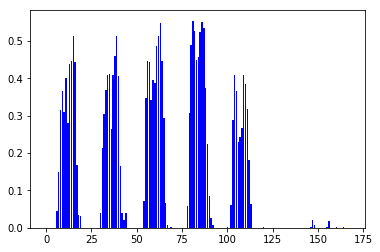

In [4]:
mean_occupancy_per_hour = mean_occupancies.to_numpy().reshape([168, 7]).sum(axis=1) / 7
labels = range(len(mean_occupancy_per_hour))
print(mean_occupancy_per_hour)
plt.bar(labels, mean_occupancy_per_hour, color="blue")
plt.show()

In [5]:
val_features, val_labels, _, _ = read_and_preprocess_data(val_in_file, batch_size=1, device_list=device_list)
test_features, test_labels, _, _ = read_and_preprocess_data(test_in_file, batch_size=1, device_list=device_list)

Hours in data:  288
File challenge/data/device_activations_val.csv has 287 timesteps (hours) until now
Hours in data:  176
File challenge/data/device_activations_test.csv has 175 timesteps (hours) until now


#### Calculate ratio of positive to negative labels per device to adjust loss function

In [6]:
def calc_ratio_positive_outputs_per_device(labels):
    ratio_per_device = np.sum(labels, axis=0) / labels.shape[0]
    print("Ratio of positive to negative outputs per device: ", ratio_per_device)
    return np.array(ratio_per_device)
ratio_positive_outputs_per_device = calc_ratio_positive_outputs_per_device(label_batch.reshape([-1, label_batch.shape[-1]]))

Ratio of positive to negative outputs per device:  [0.08333333 0.24305556 0.165      0.2375     0.23277778 0.33444444
 0.055     ]


In [7]:
USE_WEIGHTED_LOSS = True

#### Weighted loss: Scales up loss for positive labels per-device

In [8]:
# Create our own weighted loss to combat label imbalance
def weighted_loss(y_true, y_pred):
    out = -(y_true * K.log(y_pred + 1e-5) / ratio_positive_outputs_per_device + (1.0 - y_true) * K.log(1.0 - y_pred + 1e-5))
    return K.mean(out, axis=-1)

In [9]:
def create_model(params):
    """
    Creates an LSTM-based model given the parameters: 'lr', 'do', 'reg', 'lstm_units', 'n_outputs', 'n_features', 'use_weighted_loss'.
    """
    model = Sequential()
    model.add(LSTM(params['lstm_units'], batch_input_shape=(params['batch_size'], None, params['n_features']), return_sequences=True, stateful=True, kernel_regularizer=l2(params['reg'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['n_outputs'], activation='sigmoid'))
    
    adam = optimizers.Adam(lr=params['lr'])
    model.compile(loss=weighted_loss if params['use_weighted_loss'] else 'binary_crossentropy', optimizer=adam)
    return model

In [10]:
def predict_24h(model, features, labels):
    """
    Predicts a model's output for given features and the following 24 hours, reusing predictions as inputs
    """
    
    predictions = np.squeeze(model.predict(np.expand_dims(features, 0), batch_size=1))  # (n_timesteps, n_outputs)

    all_predictions = []

    last_features = np.squeeze(features)[-1]
    last_predictions = tmp_prediction = predictions[-1]
    tmp_features = np.array(last_features)
    tmp_mean_occupancies = [mean_occupancies.loc[(tmp_features[0] * 24 + tmp_features[1], 'device_' + str(j + 1)), 
                                             'mean_occupancy'] for j in range(len(device_list))]
    for i in range(24):

        tmp_features = np.concatenate([tmp_features[:2], np.round(np.squeeze(tmp_prediction)), tmp_mean_occupancies])
        
        # Increment time features
        if tmp_features[1] == 23:
            tmp_features[0] = (tmp_features[0] + 1) % 7
        tmp_features[1] = (tmp_features[1] + 1) % 24
        
        tmp_mean_occupancies = [mean_occupancies.loc[(tmp_features[0] * 24 + tmp_features[1], 'device_' + str(j + 1)), 
                                             'mean_occupancy'] for j in range(len(device_list))]
        
        tmp_prediction = np.round(model.predict(np.reshape(tmp_features, [1, 1, len(tmp_features)])))
        
        all_predictions += [tmp_prediction]

    return np.concatenate(all_predictions)

def calc_accuracy(model, params, test_X, test_Y):
    """
    Calculates accuracy of a model on a test (or validation) set. Generates sub-sequences of the test set to test on.
    The model gets i hours as inputs before having to predict the next 24 hours (i in range(48, n - 24) with 
    n = hours in test set). This gives more "effective" test set size than splitting the test set in non-overlapping
    sequences. Depending on the real world scenario, the assumption of at least 48 hours of input might be relaxed/
    strictened.
    """
    # Hack around Keras batch size restriction (to have same for training/test)
    model.save('tmp_model.h5')
    test_params = dict(params)
    test_params['batch_size'] = 1
    test_model = create_model(test_params)
    test_model.load_weights('tmp_model.h5')
    os.remove('tmp_model.h5')
    n = test_X.shape[1]
    acc_accumulated = 0.0
    for i in range(48, n - 24):
        predictions = np.squeeze(predict_24h(test_model, test_X[0, :i], test_Y[0, :i]))
        true_labels = test_Y[0, i:i+24]
        
        acc = np.sum(np.round(predictions) == true_labels) / predictions.size
        acc_accumulated += acc
    
    return acc_accumulated / (n-72) # n-72 as we leave out 48 in the beginning and 24 at the end


In [11]:
def train_model_with_params(params, train_X, train_Y):
    model = create_model(params)
    history = model.fit(train_X, train_Y, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, shuffle=False)
    return model

def eval_model_params(params, train_X, train_Y, val_X, val_Y):
    """
    Trains and evaluates a model on a given validation set by calculating its accuracy on a 24h prediction basis as 
    described in calc_accuracy().
    """
    model = train_model_with_params(params, train_X, train_Y)
    val_acc = calc_accuracy(model, params, val_X, val_Y)
    return model, val_acc


### Hyperparameter (Grid) Search
Usually I use the BayesianOptimization framework to efficiently calculate and evaluate hyperparameter spaces as GS
gets out of hand quickly in terms of computational efficiency. In this case I simply ran out of time for that,
so GS had to suffice. RS would have been an option, but I'm not too much of a fan and the training times in this 
project were "ok", so GS was my choice.

In [13]:
# skip GS by default
do_GS = False
if do_GS:
    gs_results = []
    for do in [0.0, 0.2, 0.5]:
        for units in [32, 64, 128, 256]:
            for reg in [0.0, 0.01, 0.1]:
                for n_epochs in [250]:
                    for lr in [1e-3, 1e-4]:
                        K.clear_session()
                        tmp_params = {'lr': lr, 
                                       'use_weighted_loss': USE_WEIGHTED_LOSS,
                                       'batch_size': BATCH_SIZE,
                                       'dropout': do,
                                       'epochs': n_epochs,
                                       'n_outputs': len(device_list),
                                       'n_features': feature_batch.shape[-1],
                                       'lstm_units': units,
                                       'devices': device_list,
                                       'reg': reg}
                        model, val_acc = eval_model_params(tmp_params, feature_batch, label_batch, val_features, val_labels)
                        gs_results += [(val_acc, tmp_params)]
                        print("Tmp result: ", val_acc, tmp_params)

    for x in sorted(gs_results, key=lambda x: x[0], reverse=True):
        print("Acc: {0}, params: {1}".format(x[0], x[1]))

#### Train model with results from GS to evaluate
Given the parameters from the grid search, evaluate also on the test set.

In [14]:
best_params = {'lr': 0.001, 'use_weighted_loss': True, 'batch_size': BATCH_SIZE, 'dropout': 0.0, 'epochs': 250, 'n_outputs': 7, 'n_features': 16, 'lstm_units': 128, 'devices': ['device_1', 'device_2', 'device_3', 'device_4', 'device_5', 'device_6', 'device_7'], 'reg': 0.0}
K.clear_session()

In [15]:
model, val_acc = eval_model_params(best_params, feature_batch, label_batch, val_features, val_labels)
print("Val acc for model", val_acc)

Val acc for model 0.816832779623477


In [16]:
test_acc = calc_accuracy(model, best_params, test_features, test_labels)
print("Test acc: ", test_acc)

Test acc:  0.9211165048543685


In [17]:
train_features, train_labels, _, _ = read_and_preprocess_data(in_file, batch_size=1, device_list=device_list, sequence_start_shift=20)


Hours in data:  1014
File challenge/data/device_activations_train.csv has 1013 timesteps (hours) until now


In [18]:
train_acc = calc_accuracy(model, best_params, train_features, train_labels)
print("Train acc: ", train_acc)

Train acc:  0.9620844086837648


### Saving models and parameters
Save the trained model to be reused in the inference/server script.

In [20]:
mean_occupancies.to_pickle('mean_occupancy.pkl')

model.save('model.h5')
import json

with open('params.json', 'w', encoding='utf-8') as fp:
    json.dump(best_params, fp)
    